# ========================================
# Spor Salonu Üyeleri Risk Analizi Proje Özeti
# ========================================
Bu projenin temel amacı, spor salonu üyelerinin egzersiz verilerini kullanarak, potansiyel aşırı antrenman ve kardiyak zorlanma risklerini tespit etmek ve bu risklerin demografik ve antrenman alışkanlıklarıyla nasıl ilişkili olduğunu görselleştirmektir. Analiz, üyelerin antrenmanlarının güvenliğini ve sürdürülebilirliğini artırmayı hedeflemektedir.

## Temel Metrikler
Bu projenin temelini oluşturan iki risk metriği, üyelerin antrenmanlarının verimliliğini ve güvenliğini bilimsel formüllere dayanarak ölçer.

1. THR Üstü Riski (High_Intensity_Risk)

Bu metrik, bir üyenin antrenman sırasında sürekli olarak ne kadar zorladığını gösterir ve aşırı yoğunluğu tespit etmeye yarar.

- Karvonen Formülü

Karvonen metodu, sadece yaşa bağlı maksimum kalp atış hızını değil, kişinin Dinlenme Kalp Atış Hızını (Resting_BPM) da hesaba katar. Bu sayede, kişinin gerçek seviyesine göre kişiselleştirilmiş bir hedef bölge (THR) belirlenir.

2. Teorik Maksimum Üstü Riski

Bu metrik, bir üyenin tek bir anda ulaştığı en yüksek kalp atış hızının, bilimsel olarak belirlenen üst güvenlik sınırını aşıp aşmadığını kontrol eder. Bu, direkt olarak kalbin zorlanma riskini ölçer.

# Somut Bulgular ve Analizler

1. Demografik Bulgular (Yaş ve Kilo) : Yüksek yoğunluk riskini gösteren kırmızı noktalar, Yaş ve Kilo düzlemine göreceli olarak homojen dağılmıştır. Bu durum, aşırı yoğunluk riskinin spesifik bir demografik profile değil, daha çok bireyin antrenman kararlarına ve fizyolojik durumuna bağlı olduğunu göstermektedir. Ancak, genç yaş gruplarında veya ekstrem kilo gruplarında kalbi zorlama (Teorik Maksimum Üstü) riskinde hafif kümelenmeler gözlemlenmiştir.

2. Antrenman Alışkanlıkları Bulguları :

- Yüksek Yoğunluk Riski: HIIT ve Cardio antrenman tiplerinde, özellikle haftada 3 ve 4 gün sıklıkta, risk oranı belirgin şekilde yükselmiştir. Bu, bu aktivitelerin doğası gereği yüksek stres seviyesi yarattığını doğrulamaktadır.
- Düşük Riskli Alanlar: Yoga antrenmanları ve haftada 2 gün gibi seyrek sıklıklar, her iki risk metriğinde de en düşük oranlara sahiptir.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
try:
    df = pd.read_csv("/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv("gym_members_exercise_tracking.csv")
    except FileNotFoundError:
        print("HATA: Veri dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
        raise
        
# Risk Metrikleri Hesaplama
df['HR_max_theo'] = 220 - df['Age']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['THR_high'] = (df['HRR'] * 0.85) + df['Resting_BPM']

df['High_Intensity_Risk'] = np.where(df['Avg_BPM'] > df['THR_high'], 'THR_USTU_RISK', 'Normal_Aralık')
df['Max_BPM_Risk'] = np.where(df['Max_BPM'] > df['HR_max_theo'] + 5, 'TEORIK_MAX_USTU_RISK', 'Normal_Aralık')

# Gruplama Değişkenlerini Oluşturma
df['Workout_Frequency (days/week)'] = df['Workout_Frequency (days/week)'].astype('category')

# ========================================
# Yaş ve Kilo Saçılım Grafiğinde Risk Analizi
Üyelerin Yaş ve Kilo verilerini kullanarak, riskli üyelerin demografik düzlemde nerede konumlandığını gösteren saçılım grafikleri.
# ========================================

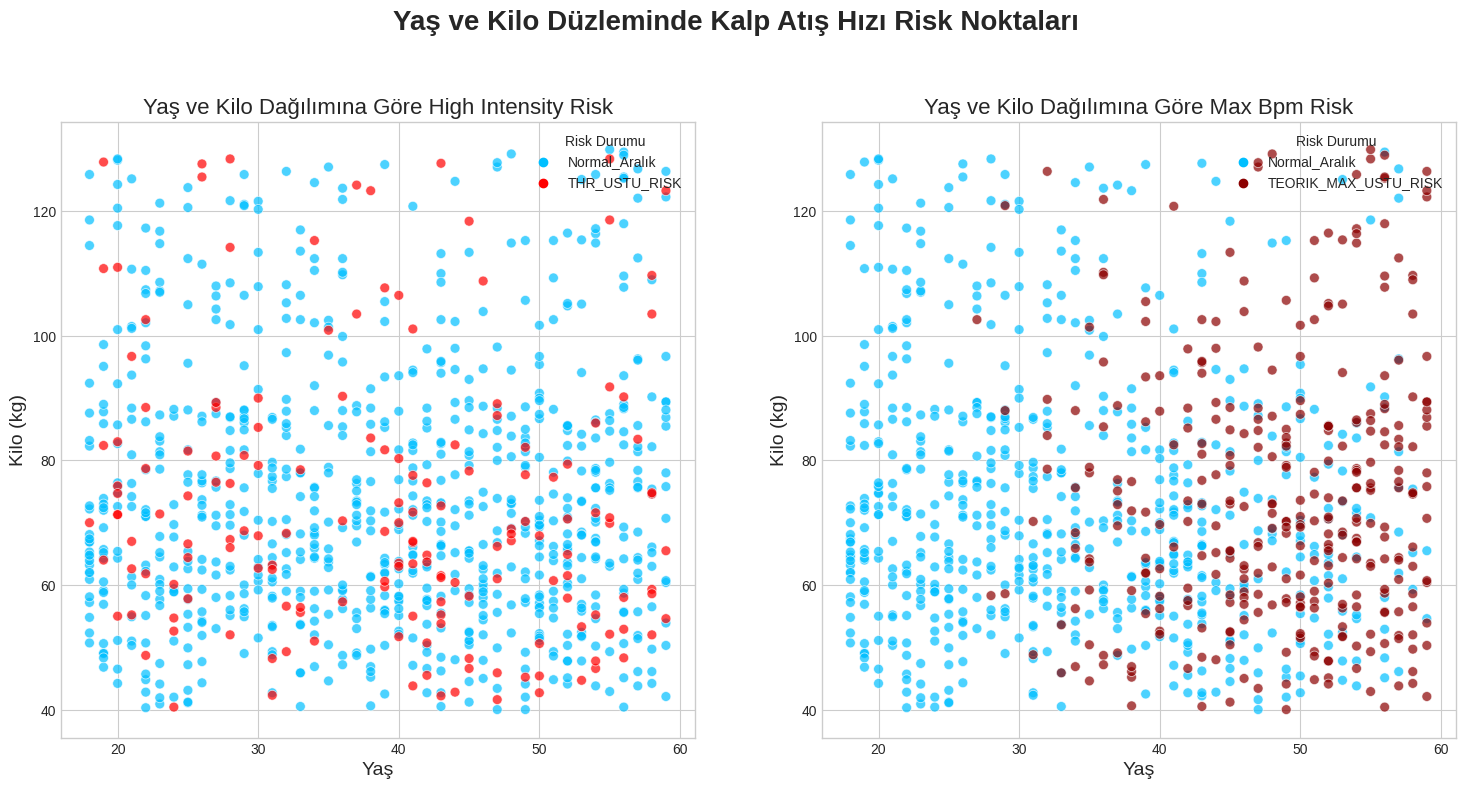

In [35]:
risk_metrics = ['High_Intensity_Risk', 'Max_BPM_Risk']

fig1, axes1 = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.2)
plt.style.use('seaborn-v0_8-whitegrid')

for i, metric in enumerate(risk_metrics):
    ax = axes1[i]
    
    df_sorted = df.sort_values(by=metric, ascending=True)
    
    palette = {'Normal_Aralık': 'deepskyblue', 
               'THR_USTU_RISK': 'red', 
               'TEORIK_MAX_USTU_RISK': 'darkred'}
               
    sns.scatterplot(x='Age', y='Weight (kg)', data=df_sorted, 
                    hue=metric, palette=palette, s=50, alpha=0.7, ax=ax)
    
    ax.set_title(f'Yaş ve Kilo Dağılımına Göre {metric.replace("_", " ").title()}', fontsize=16)
    ax.set_xlabel('Yaş', fontsize=14)
    ax.set_ylabel('Kilo (kg)', fontsize=14)
    ax.legend(title='Risk Durumu', loc='upper right')

fig1.suptitle("Yaş ve Kilo Düzleminde Kalp Atış Hızı Risk Noktaları", y=1.02, fontsize=20, weight='bold')
plt.show()

# ========================================
# Antrenman Tipi ve Sıklığı Risk Analizi
Bu ısı haritası, spor salonu üyelerinin Antrenman Tipleri ile Haftalık Antrenman Sıklıkları arasındaki etkileşimi, kalp atış hızı riski açısından göstermektedir.
# ========================================

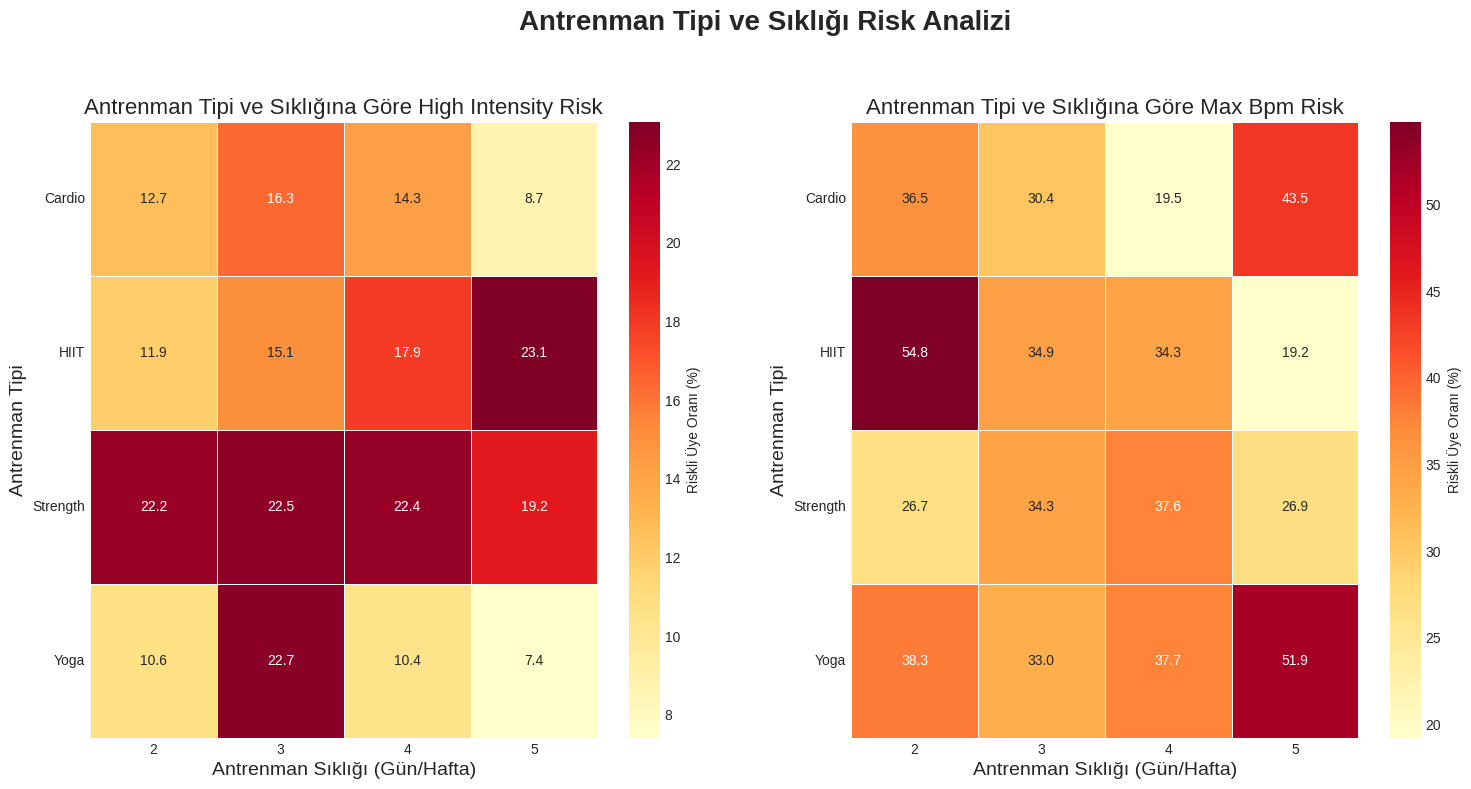

In [36]:
risk_metrics = ['High_Intensity_Risk', 'Max_BPM_Risk']

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.2)
plt.style.use('seaborn-v0_8-whitegrid')

for i, metric in enumerate(risk_metrics):
    ax = axes2[i]
    
    # Isı Haritası için Pivot Tablo Oluşturma:
    df['is_risky'] = (df[metric] != 'Normal_Aralık').astype(int)
    
    # Pivot tabloyu oluştur ve ortalamayı al
    risk_pivot = df.pivot_table(index='Workout_Type', columns='Workout_Frequency (days/week)', 
                                 values='is_risky', aggfunc='mean', observed=True) * 100 # Yüzdeye çevir
    
    # Isı Haritasını Çizme
    sns.heatmap(risk_pivot, annot=True, fmt=".1f", cmap="YlOrRd", 
                linewidths=.5, cbar_kws={'label': 'Riskli Üye Oranı (%)'}, ax=ax)
    
    ax.set_title(f'Antrenman Tipi ve Sıklığına Göre {metric.replace("_", " ").title()}', fontsize=16)
    ax.set_xlabel('Antrenman Sıklığı (Gün/Hafta)', fontsize=14)
    ax.set_ylabel('Antrenman Tipi', fontsize=14)
    ax.tick_params(axis='y', rotation=0)

fig2.suptitle("Antrenman Tipi ve Sıklığı Risk Analizi", y=1.02, fontsize=20, weight='bold')
plt.show()